# Fit Ni PDF

This is an example of using the DiffPy-CMI framework to fit a Ni neutron PDF. It illustrates how to build a simple fit recipe with a PDF data file and a structure uploaded from a cif file. It should be straightforward to adapt this example to fit your own data.  Simply replace the ``dataFile`` and ``structureFile`` variables with your own and modify the ``spaceGroup`` variable as appropriate.

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize.minpack import leastsq

# DiffPy-CMI modules for building a fitting recipe
from diffpy.Structure import loadStructure
from diffpy.srfit.pdf import PDFContribution
from diffpy.srfit.fitbase import FitRecipe, FitResults

from diffpy.srfit.structure import constrainAsSpaceGroup


In [2]:
%matplotlib notebook

Specify the files containing our experimental data and structure file



In [3]:
dataFile = "ni-q27r100-neutron.gr"
structureFile = "ni.cif"
spaceGroup = "Fm-3m"

 The first thing to construct is a contribution. Since this is a simple example, the contribution will simply contain our PDF data and an associated structure file. We'll give it the name "nickel".

In [4]:
niPDF = PDFContribution("nickel")

Load the data and set the r-range over which we'll fit

In [5]:
niPDF.loadData(dataFile)
niPDF.setCalculationRange(xmin=1, xmax=20, dx=0.01)

Add the structure from our cif file to the contribution.

In [6]:
niStructure = loadStructure(structureFile)
niPDF.addStructure("nickel", niStructure)

[Ni   0.000000 0.000000 0.000000 1.0000, Ni   0.000000 0.500000 0.500000 1.0000, Ni   0.500000 0.000000 0.500000 1.0000, Ni   0.500000 0.500000 0.000000 1.0000]

The FitRecipe does the work of calculating the PDF with the fit variable that we give it.

In [7]:
niFit = FitRecipe()

Give the PDFContribution to the FitRecipe.

In [8]:
niFit.addContribution(niPDF)

Configure the fit variables and give them to the recipe.  We can use the srfit function constrainAsSpaceGroup to constrain the lattice and ADP parameters according to the Fm-3m space group.

In [9]:
spaceGroupParams = constrainAsSpaceGroup(niPDF.nickel.phase, spaceGroup)
print("Space group parameters are:",
      ', '.join(p.name for p in spaceGroupParams))

Space group parameters are: a, Uiso_0


We can now cycle through the parameters and activate them in the recipe as variables.

In [10]:
for par in spaceGroupParams.latpars:
    niFit.addVar(par)

Set initial value for the ADP parameters, because CIF had no ADP data.

In [11]:
for par in spaceGroupParams.adppars:
    niFit.addVar(par, value=0.005)

As usual, we add variables for the overall scale of the PDF and a delta2 parameter for correlated motion of neighboring atoms.

In [12]:
niFit.addVar(niPDF.scale, 1)
niFit.addVar(niPDF.nickel.delta2, 5)

We fix Qdamp based on prior information about our beamline.


In [13]:
niFit.addVar(niPDF.qdamp, 0.03, fixed=True)

Turn off the option to printout refinement iteration number.

In [14]:
niFit.clearFitHooks()

We can now execute the fit using scipy's least square optimizer.

In [15]:
print("Refine PDF using scipy's least-squares optimizer:")
print("  variables:", niFit.names)
print("  initial values:", niFit.values)

leastsq(niFit.residual, niFit.values) #running the refinement

print("  final values:", niFit.values)

Refine PDF using scipy's least-squares optimizer:
  variables: ['a', 'Uiso_0', 'scale', 'delta2']
  initial values: [3.52387 0.005   1.      5.     ]
  final values: [3.52672556 0.00575098 1.06324515 2.21296015]


Obtain and display the fit results.

In [16]:
niResults = FitResults(niFit)
print("FIT RESULTS\n")
print(niResults)

FIT RESULTS

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       297.52170572
Contributions  297.52170572
Restraints     0.00000000
Chi2           297.52170572
Reduced Chi2   0.15683801
Rw             0.06564119

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Uiso_0  5.75098300e-03 +/- 4.41392793e-05
a       3.52672556e+00 +/- 1.13341756e-04
delta2  2.21296015e+00 +/- 1.06615283e-01
scale   1.06324515e+00 +/- 6.05306336e-03

Fixed Variables
------------------------------------------------------------------------------
qdamp  3.00000000e-02

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
corr(Uiso_0, scale)   0.6864



Now, to plot the observed and refined PDF.

First, extract the data from the fit profile.

In [17]:
r = niFit.nickel.profile.x
gobs = niFit.nickel.profile.y

Next, get the calculated PDF and compute the difference between the calculated and measured PDF.

In [18]:
gcalc = niFit.nickel.evaluate()
baseline = 1.1 * gobs.min()
gdiff = gobs - gcalc

Finally, generate the plot.

<IPython.core.display.Javascript object>


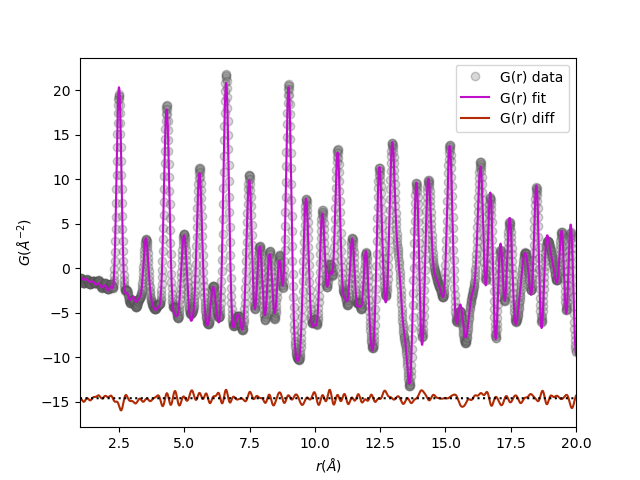

In [19]:
# Plot!
plt.figure()
plt.plot(r, gobs, 'o', color='.5', markeredgecolor='.3', label="G(r) data",ms=6,alpha=.3)
plt.plot(r, gcalc, '-',color='#bf0ecc', label="G(r) fit",lw=1.5)
#plt.plot(r, gcalc, '-',color='#16d7f9', label="G(r) fit",lw=1)
plt.plot(r, gdiff + baseline, '-', c='#b22b05', label="G(r) diff")
plt.plot(r, np.zeros_like(r) + baseline, 'k:')
plt.xlabel(r"$r (\AA)$")
plt.ylabel(r"$G (\AA^{-2})$")

plt.xlim(r.min(),r.max())

plt.legend()